<div style="background-color:#342184; padding:6px; color:#f3f0ff;">

# Try Finesse 3

</div>


In this interactive notebook we introduce <a href=http://www.gwoptics.org/finesse/>Finesse 3</a> We are using the <a href="https://www.python.org/">Python</a> programming language, executed in <a href="http://jupyter.org/">Jupyter</a> notebooks. Even if you are not familiar with Python we expect that you will be able to play around with the provided examples.

You can experiment with the live code presented here, create your own notebook (`File > New Notebook`), or upload a notebook you wish to test-run. Note that **changes are not saved after exiting the Binder session**, so you should download a local copy of any notebooks you wish to retain. (This notebook requires the following image files nodal_network.svg, model_sketch.svg, fabry-perot02.svg, michelson_with_nodes.svg).

We introduce the new version of the interferometer modelling software Finesse which was developed for the design and commissioning of laser-interferometric gravitational wave detectors. It is optimised for modelling the main interferometers of LIGO, Virgo, GEO etc, but it is also a simple and versatile tool to learn basic laser optics. 

See below, at the end of the notebook, for links to more information about Python, Jupyter and Finesse.

### In this notebook

Finesse numerically models optical systems in the _frequency domain_. This notebook demonstrates simple tasks: modelling the amount of light transmitted or reflected by a single beamsplitter or by a 2-mirror optical cavity. You can learn more about 2-mirror cavities, also known as Fabry-Perot  cavities or interferometers, by reading <a href=https://link.springer.com/article/10.1007/s41114-016-0002-8#Sec33>section 5.1</a> of Interferometer Techniques for Gravitational-Wave Detection and <a href=http://www.gwoptics.org/learn/02_Plane_waves/01_Fabry_Perot_cavity/>section 2</a> of the Learn Laser Interferometry course (note that the course uses the previous version of the software, Finesse 2). 

You may wish to open the <a href="https://finesse.ifosim.org/docs/latest/">Finesse 3 documentation</a> in another tab to look up the Finesse syntax. 

# Getting started

First we import Finesse and some other Python packages into the notebook.

(type shift+enter to execute commands and the cells)


In [1]:
import finesse
import matplotlib.pyplot as plt
from finesse.analysis.actions import Xaxis
finesse.init_plotting()

# Setting up a model and running a simulation
## Model = a network of components

In the most simple case, we can think of the model as a set of **optical components** connected to each other via **nodes**. The nodes are virtual connection points between the components and are accessed via **ports**, e.g., optical ports contain two nodes, an input node (`component.p1.i`) and an output node (`component.p1.o`). They have unique names and store which components they are connected to. This allows for the analysis of the interferometer structure by traversing the list of existing nodes. Such a system is also called a **nodal network**. For example, a system of two mirrors separated by a distance would be modelled as three components (mirror, space, mirror). The mirrors have two optical ports, each with an input node and and output node:

<div style="background-color:white; padding: 1em; text-align:center"><img src="nodal_network.svg" width=70% /></div>

Nodes are accessed using dot (`.`) notation starting with the component name, e.g., the input node `i` in the `p1` optical port of the second mirror can be accessed with `m2.p1.i`.

The 'space' is also an optical component because the free propagation changes the phase of the light beam, and anything that changes a property of the light field is treated as a component by definition. A space connects two components via optical ports, e.g., the space above connects the two mirrors with `s s1 mirror1.p2 mirror2.p1`.

## Simulation = making a plot

Many simulation tasks can be thought of as making a plot: we look at an interferometer output signal when varying an interferometer parameter, e.g., a mirror position. An interferometer can have many output signals, most of which are the signals of photodetectors. Thus, in Finesse 3, a typical simulation task is defined by:
  1. creating the optical model by specifying the components
  2. adding the desired detectors to create output signals
  3. varying a parameter (using the `Xaxis` action)

# A First Model

Let's construct a simple Finesse model of a laser beam shining on a beamsplitter. In this simulation, we'll just vary the input laser power and see how much light is transmitted through the beamsplitter. To measure the laser power, we connect a photodiode to the correct node at the beamsplitter.

The sketch below shows a sketch the setup and also a diagram of the equivalent nodal network:

<div style="background-color:white; padding:1em; text-align:center;">
<img src="model_sketch.svg" width="60%" />
</div>

## 1) Creating the optical model

We'll start by creating the optical model by specifying the components. The Finesse 3 code for this setup looks as follows:

In [2]:
# create a new Finesse model object,
# this serves as the foundation of the simulation, so we'll name it `base`
base = finesse.Model()

# setup of the interferometer, each line is one component
code = """
l laser1 P=1                # laser with P = 1W at the default frequency
s s1 laser1.p1 bs1.p1 L=1   # 1m space connecting the laser to the beamsplitter
bs bs1 R=0.5 T=0.5          # 50:50 beam splitter
"""

# parsing the setup description to generate the model
base.parse(code)

## 2) Adding detectors

We can then decide the output we would like to produce by adding detectors. We'll want to first produce a copy (via the "deepcopy" method) of the base model so it can be reused for other simulations.

In [3]:
# copy the base model
ifo1 = base.deepcopy()

# adding a photodiode detecting the transmitted light
ifo1.parse("pd pow_t bs1.p3.o")

## 3) Varying a parameter

In Finesse 3, we can vary a parameter using the `Xaxis` action. This action will run the simulation for a range of parameter values and return a `Solution` object. Actions are executed using the model's `run()` method.

For this simulation, we will vary the laser power (`laser1.P`) linearly from 0 Watts to 1 Watt in 100 steps to see what the detector produces:

In [4]:
# Run the simulation and change the laser power from 0 to 1W in 10 steps
out1 = ifo1.run(Xaxis('laser1.P', 'lin', 0, 1, 10))

The output data can be plotted in multiple ways. If you want to see the results quickly we suggest using the built-in `plot()` function:

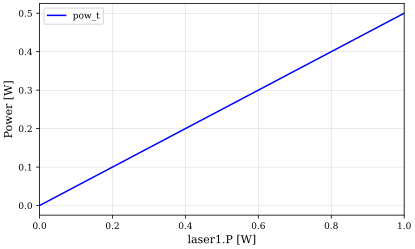

In [5]:
# plotting the results of an output can be done using the built-in command
fig = out1.plot()

This will produce a plot using all the detectors enabled in the model.

However, if you would rather make a plot yourself you can always just use `matplotlib` commands as per usual:

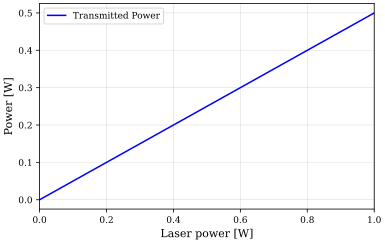

In [6]:
fig = plt.figure()
plt.plot(out1.x1, out1["pow_t"], label="Transmitted Power")
plt.xlim(out1.x1.min(), out1.x1.max())
plt.ylabel("Power [W]")
plt.xlabel("Laser power [W]")
plt.legend()
plt.show()

The `Solution` object returned by running the `Xaxis` action is important as it contains all the results from the simulation as an array of numbers: the steps in the simulation are accessed as an array via `out.x1` and each detector can be accessed by name, e.g., `out['pow_t']`.

You can see the raw outputs with:

In [7]:
print(out1.x1) # show the xaxis values
print(out1['pow_t']) # show the detector values
print(out1.detectors) # show the available detectors

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]
('pow_t',)


# Tasks
The rest of the notebook provides some example code as tasks. We recommend that you make a copy of the notebook, delete the code and try to solve the tasks by recreating the code yourself.

## Task 1: Check for power conservation

Do the following:
  1. Copy the previous model with `ifo2 = base.deepcopy()`, this allows for edits without changing the original.
  2. Add two photodetectors `pow_t` and `pow_r` to the new `ifo2` model to measure the transmitted and reflected light.
  3. Run this model with `ifo2.run()` to get the simulation output.
  4. Check if the reflected and transmitted power match up with the input power.

In [8]:
ifo2 = base.deepcopy()

ifo2.parse("""
pd pow_t bs1.p3.o
pd pow_r bs1.p2.o
""")

out2 = ifo2.run()
print(f"{out2['pow_t']+ out2['pow_r']:.2}")

1.0


## Task 2: Add interferometer arms

Do the following:
  1. Copy the base model and turn the setup into a Michelson interferometer by adding a space and a mirror to the transmitted and reflection ports of the beamsplitter (`bs1.p3` and `bs1.p2`, respectively).
  2. Set the length of the spaces to 3km (`L=3e3`) and set the mirrors to be perfectly reflective (`R=1 T=0`).
  3. Detect the power at the combined output node of the beamsplitter (`bs1.p4.o`).
  4. Vary the microscopic tuning of the end mirror (`ETMx.phi`) from 0 degree to 180 degree in $200$ steps. The microscopic tuning is given in degrees with 360 degrees being equivalent to one wavelength $\lambda$, see the end of the notebook below for more information on that.
  5. Plot the simulation output.
 
<div style="background-color:white; padding:1em; text-align:center;">
<img src="michelson_with_nodes.svg" width="70%" />
</div>

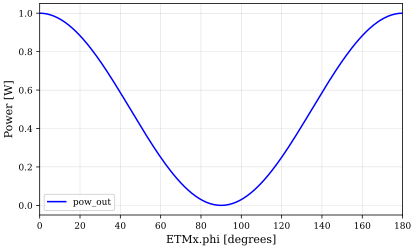

In [9]:
ifo3 = base.deepcopy()

ifo3.parse("""
# add the X arm
m ETMx R=1 T=0
s Lx bs1.p3 ETMx.p1 L=3k

# add the Y arm
m ETMy R=1 T=0
s Ly bs1.p2 ETMy.p1 L=3k

# detect the interference
pd pow_out bs1.p4.o
""")

out3 = ifo3.run(Xaxis('ETMx.phi', 'lin', 0, 180, 200))

out3.plot()
plt.show()

In [10]:
print(ifo3.unparse())


l laser1 P=1                # laser with P = 1W at the default frequency
s s1 laser1.p1 bs1.p1 L=1   # 1m space connecting the laser to the beamsplitter
bs bs1 R=0.5 T=0.5 L=0.0
m ETMx R=1 T=0 L=0.0
s Lx bs1.p3 ETMx.p1 L=3k          # 50:50 beam splitter
m ETMy R=1 T=0 L=0.0
s Ly bs1.p2 ETMy.p1 L=3k
pd pow_out bs1.p4.o
# Items below could not be matched to original script, or were not present when the model was originally parsed.






## Task 3: Investigate optical losses

Do the following:
  1. Add losses to `ETMx` by setting R and T such that $R+T<1$, for example you can set the reflectivity to 70% with: `[mymodel].ETMx.R = 0.7`.
  2. Detune the mirror just as in Task 2.
  3. Plot the results from both simulations in the same plot.

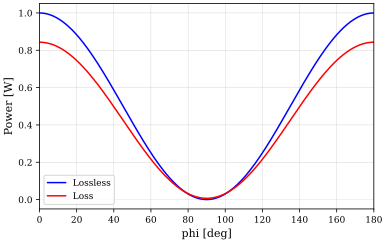

In [10]:
# add loss
ifo3.ETMx.R = 0.7

# scan the end mirror
out3b = ifo3.run(Xaxis('ETMx.phi', 'lin', 0, 180, 200))

# plot both results
fig = plt.figure()
plt.plot(out3.x1, out3["pow_out"], label="Lossless")
plt.plot(out3b.x1, out3b["pow_out"], label="Loss")
plt.xlim(out3.x1.min(), out3.x1.max())
plt.ylabel("Power [W]")
plt.xlabel("phi [deg]")
plt.legend()
plt.show()

## Task 4: Make a cavity

Optical cavities are based on the the original idea for a spectroscopy standard published by Fabry and Perot in 1899. Cavities are a fundamental building block of current gravitational wave detectors and an important instrument in laser optics. 

<div style="background-color:white; padding:1em; text-align:center;">
<img src="fabry-perot.svg" width="70%" />
</div>

This is a sketch of the setup that we want to model. It consists of two mirrors `m1` and `m2` which are $L$ meters apart. On the input side we have a laser and a beamsplitter. The beamsplitter is used to separate the input from the reflected light for detection. There is also a photodiode on transmission to measure the light passing through the cavity. 

Your tasks are:
1. Create a new model describing the optical layout of a cavity.
2. Run two simulations to show how the two cavity powers vary over these two variables:
    1. the microscopic position of the end mirror (`m2.phi`)
    2. the laser frequency (`laser1.f`)

Your plots should show a few resonances of the cavity.


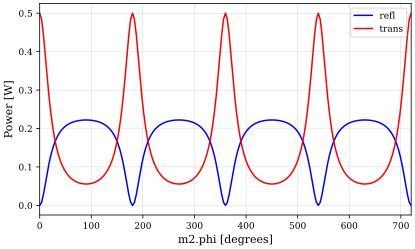

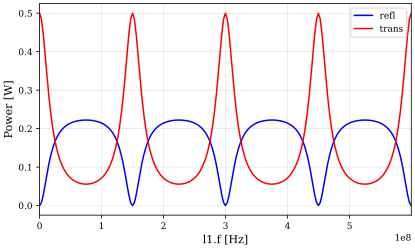

In [11]:

ifo4 = finesse.Model()

ifo4.parse("""
# ifo
l l1
s s1 l1.p1 bs1.p1
bs bs1
s s2 bs1.p3 m1.p1
m m1
s s3 m1.p2 m2.p1 L=1
m m2

# detectors
pd refl bs1.p4.o
pd trans m2.p2.o
""")

# We expect cavity resonance when cavity length is integer number of half wavelengths
out4 = ifo4.run(Xaxis('m2.phi', 'lin', 0, 4*180, 200))
out4.plot()

# We expect cavity resonance when f = n*C/L
import finesse.constants as constants

out5 = ifo4.run(Xaxis('l1.f', 'lin', 0, 4*(constants.C_LIGHT/ifo4.s3.L/2), 200))
out5.plot()
plt.show()

# Additional Info

## References for Python, Jupyter, and Finesse 3

*Info and reference material for Finesse 3 *:
  * <a href="https://finesse.docs.ligo.org/finesse3/">Finesse 3 documentation</a>
  * <a href="https://git.ligo.org/finesse/finesse3">Finesse 3 source code</a>

*Info and reference material for Finesse 2 *:
  * <a href="http://www.gwoptics.org/finesse">Finesse 2 main page</a>
  * <a href="http://www.gwoptics.org/finesse/reference/">Finesse 2 online syntax reference</a>
  * <a href="http://kvasir.sr.bham.ac.uk/redmine/attachments/download/131/Finesse_2.0_manual.pdf">Finesse 2 manual</a> (>200 pages pdf file)
  * <a href="http://www.gwoptics.org/learn/">Learn Laser Interferometry</a>, our online collection of notebooks such as this one
  * <a href='http://www.gwoptics.org/learn/01_Introduction/01_Getting_Started/03_Pykat.html'>reference notebook for Pykat</a>
  
*Some info and reference material on Python and Jupyter *:
  <!-- removed because only for Python 2.7 -->
  <!-- * A <a href="http://nbviewer.ipython.org/gist/rpmuller/5920182">Crash Course in Python for Scientists</a> -->
  * The <a href="https://docs.python.org/3/tutorial/index.html">Python tutorial</a> and a <a href="https://numpy.org/doc/stable/user/absolute_beginners.html">Numpy tutorial</a>
  * The <a href="https://jupyter.org/">Jupyter project page</a>
  * The text cells in this notebook are fomatted using <a href="https://daringfireball.net/projects/markdown/syntax">Markdown</a>


## Mirror positions and tunings

One of the most crucial aspects in optical interferometery is accurately positioning mirrors. The optical wavelengths we use in current gravitational wave detectors is $\lambda=1064nm$. Typically we are interested in either **macroscopic** positioning, such as a mirror is 1m, 1cm, 1mm, etc. away, or in **microscopic** positions which are fractions of $\lambda$. The resonance condition of a Fabry-Perot cavity requires its length to be an integer number of half-wavelengths and for modelling its behaviour length differences $\ll \lambda=1064$ nm are of interest. Some orders of magnitude:
  * LIGO peak senitivity in meters: $\sim 10^{-20}$ m
  * LIGO cavity mirror postion control accuracy: $< 10^{-12}$ m
  * LIGO arm cavity length: $\sim 10^3$ m
  * Relative numerical accuracy of floating point numbers: $10^{-15}$

As we can see there are many orders of magnitude difference between the lengths of cavities and the types of signal we might measure. With such a large dynamic range typical floating point variables used in computers cannot represent this. Thus we break lengths up into macroscopic and microscopic lengths. The length given by the `space` component are macroscopic and are always rounded to the nearest integer number of $\lambda$.

We change the microscopic length differences in Finesse by changing the mirrors *tuning* value. Tuning is usually refered to in units of degrees, 360 degrees $= \lambda$. So a tuning of 180 degrees means we have moved the mirror by half a wavelength.
You can read more about this in the <a href="https://link.springer.com/article/10.1007/s41114-016-0002-8">Living Review article</a>, section 2.5, "Lengths and tunings: numerical accuracy of distances".
